In [8]:
import xarray as xr
import numpy as np
import copy
from shapely.geometry import box
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [9]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [10]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32633 = big_pv_geoms.to_crs(32633)

# Add 20 m buffer to download sentinel-2 data 
big_pv_geoms_32633_buffer_20 = copy.deepcopy(big_pv_geoms_32633)
big_pv_geoms_32633_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32633_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32633_buffer_20.to_crs(4326)

In [11]:
farm_id = 2028 #278
data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
geom = big_pv_geoms_32633.iloc[farm_id]
geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)


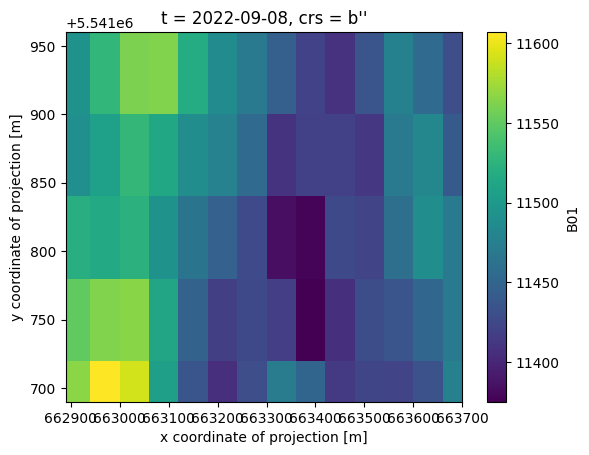

In [20]:
data['B01'][50].plot()

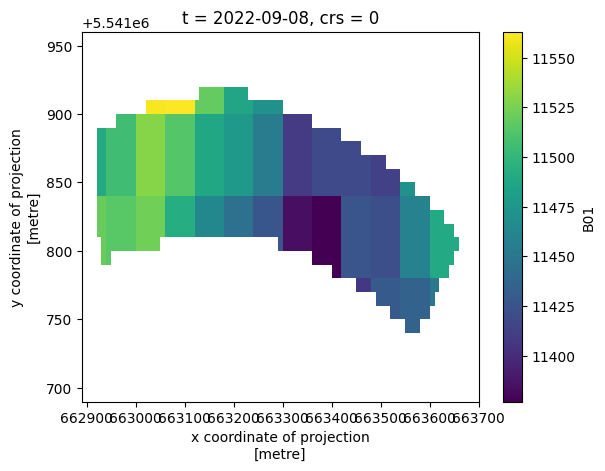

In [21]:
clipped['B01'][50].plot()

In [22]:
image_array = clipped.variables["B01"][0, :]

#Find the bounding box coordinates
valid_indices = np.where(~np.isnan(image_array))
xmin, ymin = np.min(valid_indices[1]), np.min(valid_indices[0])
xmax, ymax = np.max(valid_indices[1]), np.max(valid_indices[0])
bbox_coords = (xmin, ymin, xmax, ymax)
bbox_coords

(3, 4, 76, 21)

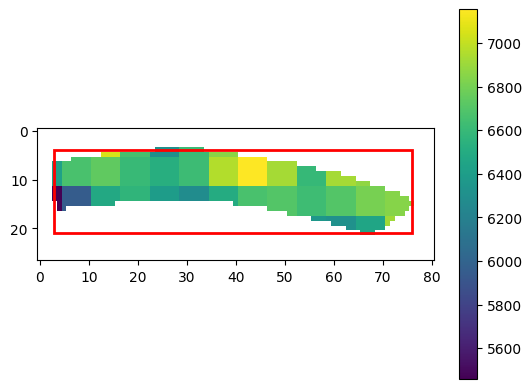

In [23]:
plt.imshow(image_array , cmap='viridis')
plt.colorbar()

# Step 4: Plot the rectangular bounding box
bbox = Rectangle((bbox_coords[0], bbox_coords[1]), 
                 bbox_coords[2] - bbox_coords[0], 
                 bbox_coords[3] - bbox_coords[1], 
                 linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(bbox)

plt.show()

In [17]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

data_arrays = []
for band in bands: 
    image_array = data.variables["B01"][:]
    data_arrays.append(image_array)
    
    
image_px_coords = np.stack(data_arrays)

In [18]:
image_px_coords.shape

(11, 73, 63, 77)

### New test

In [6]:
pv_od = gpd.read_file(f"{data_dir}/germany_OD2.shp")

In [7]:
pv_od

,id,geometry
0,1.0,"POLYGON ((12.86969 52.60196, 12.87146 52.60182..."
1,11.0,"POLYGON ((13.32402 50.88435, 13.32670 50.88423..."
2,15.0,"POLYGON ((10.28125 49.96902, 10.28074 49.96902..."
3,19.0,"POLYGON ((7.06390 49.30741, 7.06463 49.30804, ..."
4,21.0,"POLYGON ((11.97309 51.24609, 11.97322 51.24607..."
...,...,...
1546,98172.0,"POLYGON ((12.01969 49.64215, 12.01943 49.64256..."
1547,98300.0,"POLYGON ((12.55756 48.51611, 12.55717 48.51768..."
1548,98301.0,"POLYGON ((12.56626 48.51478, 12.56654 48.51469..."
1549,98620.0,"POLYGON ((12.14655 49.91413, 12.14910 49.91323..."
